<a href="https://colab.research.google.com/github/FernandoRossiPython/FernandoRossiPython/blob/main/Desafio_DIO_Learning_Machine_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%matplotlib inline

import os

#if using Theano with GPU
#os.environ["KERAS_BACKEND"] = "tensorflow"

import random
import numpy as np
import keras

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model

In [3]:
!curl -L "https://data.caltech.edu/records/mzrjq-6wc02/files/caltech-101.zip?download=1" -o caltech-101.zip
!unzip caltech-101.zip
print(os.listdir())


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   476  100   476    0     0   1823      0 --:--:-- --:--:-- --:--:--  1830
100  131M  100  131M    0     0  34.1M      0  0:00:03  0:00:03 --:--:-- 43.0M
Archive:  caltech-101.zip
replace __MACOSX/._caltech-101? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: __MACOSX/._caltech-101  
  inflating: caltech-101/101_ObjectCategories.tar.gz  
  inflating: __MACOSX/caltech-101/._101_ObjectCategories.tar.gz  
  inflating: caltech-101/show_annotation.m  
  inflating: __MACOSX/caltech-101/._show_annotation.m  
  inflating: caltech-101/Annotations.tar  
  inflating: __MACOSX/caltech-101/._Annotations.tar  
['.config', 'caltech-101.zip', 'caltech-101', '_101_ObjectCategories.tar.gz', '__MACOSX', '101_ObjectCategories', 'sample_data']


In [4]:
import tarfile
tar = tarfile.open('caltech-101/101_ObjectCategories.tar.gz', 'r:gz')
tar.extractall()
tar.close()

In [5]:
root = '101_ObjectCategories'
exclude = ['BACKGROUND_Google', 'Motorbikes', 'airplanes', 'Faces_easy', 'Faces']
train_split, val_split = 0.7, 0.15

categories = [x[0] for x in os.walk(root) if x[0]][1:]
categories = [c for c in categories if c not in [os.path.join(root, e) for e in exclude]]

print(categories)

['101_ObjectCategories/scorpion', '101_ObjectCategories/lotus', '101_ObjectCategories/stop_sign', '101_ObjectCategories/watch', '101_ObjectCategories/butterfly', '101_ObjectCategories/umbrella', '101_ObjectCategories/metronome', '101_ObjectCategories/Leopards', '101_ObjectCategories/mandolin', '101_ObjectCategories/pizza', '101_ObjectCategories/starfish', '101_ObjectCategories/rhino', '101_ObjectCategories/cannon', '101_ObjectCategories/brontosaurus', '101_ObjectCategories/cougar_face', '101_ObjectCategories/electric_guitar', '101_ObjectCategories/yin_yang', '101_ObjectCategories/laptop', '101_ObjectCategories/revolver', '101_ObjectCategories/stapler', '101_ObjectCategories/sea_horse', '101_ObjectCategories/sunflower', '101_ObjectCategories/inline_skate', '101_ObjectCategories/dragonfly', '101_ObjectCategories/cup', '101_ObjectCategories/scissors', '101_ObjectCategories/gerenuk', '101_ObjectCategories/dalmatian', '101_ObjectCategories/anchor', '101_ObjectCategories/grand_piano', '101_O

In [6]:
# helper function to load image and return it and input vector
def get_image(path):
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

In [7]:
data = []
for c, category in enumerate(categories):
    images = [os.path.join(dp, f) for dp, dn, filenames
              in os.walk(category) for f in filenames
              if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
    for img_path in images:
        img, x = get_image(img_path)
        data.append({'x':np.array(x[0]), 'y':c})

# count the number of classes
num_classes = len(categories)

In [8]:
random.shuffle(data)

In [9]:
idx_val = int(train_split * len(data))
idx_test = int((train_split + val_split) * len(data))
train = data[:idx_val]
val = data[idx_val:idx_test]
test = data[idx_test:]

In [10]:
x_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]
x_val, y_val = np.array([t["x"] for t in val]), [t["y"] for t in val]
x_test, y_test = np.array([t["x"] for t in test]), [t["y"] for t in test]
print(y_test)

[34, 5, 19, 73, 19, 37, 74, 41, 73, 12, 41, 10, 19, 83, 27, 73, 14, 15, 93, 33, 4, 58, 54, 70, 68, 73, 90, 3, 62, 79, 44, 43, 45, 46, 3, 65, 48, 47, 15, 87, 19, 34, 57, 73, 79, 86, 45, 76, 73, 91, 20, 30, 10, 36, 43, 76, 25, 51, 31, 68, 11, 86, 77, 81, 51, 34, 16, 81, 81, 28, 19, 3, 89, 21, 43, 17, 60, 95, 25, 54, 57, 52, 36, 28, 14, 1, 16, 70, 90, 55, 18, 3, 76, 45, 86, 58, 67, 45, 48, 45, 54, 26, 17, 54, 88, 78, 54, 15, 3, 63, 5, 74, 3, 40, 63, 42, 5, 43, 83, 59, 55, 12, 92, 82, 72, 15, 73, 36, 60, 89, 66, 55, 85, 71, 69, 10, 3, 20, 18, 52, 7, 54, 54, 78, 56, 48, 13, 56, 91, 4, 13, 37, 92, 76, 77, 7, 17, 62, 30, 30, 7, 86, 74, 70, 15, 2, 37, 45, 39, 90, 14, 42, 65, 59, 38, 43, 51, 7, 78, 18, 43, 5, 35, 8, 86, 18, 24, 17, 90, 4, 73, 11, 92, 16, 57, 3, 10, 30, 78, 16, 10, 74, 31, 73, 19, 73, 37, 7, 3, 22, 82, 38, 96, 42, 37, 24, 87, 15, 42, 47, 77, 50, 93, 27, 44, 9, 60, 44, 7, 89, 83, 25, 24, 7, 21, 9, 84, 85, 82, 7, 46, 1, 43, 33, 54, 18, 58, 21, 27, 49, 13, 29, 29, 70, 91, 95, 57, 7

In [11]:
# normalize data
x_train = x_train.astype('float32')
x_val = x_val.astype('float32')
x_test = x_test.astype('float32')

# convert labels to one-hot vectors
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(y_test.shape)

(932, 97)


In [12]:
# summary
print("finished loading %d images from %d categories"%(len(data), num_classes))
print("train / validation / test split: %d, %d, %d"%(len(x_train), len(x_val), len(x_test)))
print("training data shape: ", x_train.shape)
print("training labels shape: ", y_train.shape)

finished loading 6209 images from 97 categories
train / validation / test split: 4346, 931, 932
training data shape:  (4346, 224, 224, 3)
training labels shape:  (4346, 97)


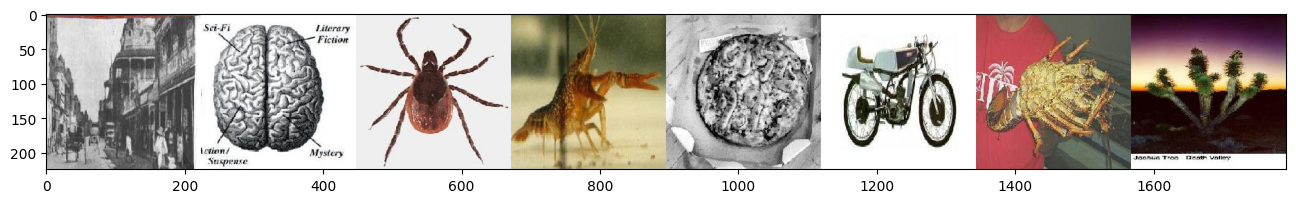

In [13]:
images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(root) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
idx = [int(len(images) * random.random()) for i in range(8)]
imgs = [image.load_img(images[i], target_size=(224, 224)) for i in idx]
concat_image = np.concatenate([np.asarray(img) for img in imgs], axis=1)
plt.figure(figsize=(16,4))
plt.imshow(concat_image)

In [14]:
# build the network
model = Sequential()
print("Input dimensions: ",x_train.shape[1:])

model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

Input dimensions:  (224, 224, 3)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 222, 222, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 109, 109, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 52, 52, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 97)             │        24,929 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 97)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,233,473 (4.71 MB)

 Trainable params: 1,233,473 (4.71 MB)

 Non-trainable params: 0 (0.00 B)

In [1]:
# compile the model to use categorical cross-entropy loss function and adadelta optimizer
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=10,
                    validation_data=(x_val, y_val))

NameError: name 'model' is not defined

In [2]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_acc"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

NameError: name 'plt' is not defined

In [ ]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

In [ ]:
vgg = keras.applications.VGG16(weights='imagenet', include_top=True)
vgg.summary()

In [ ]:
# make a reference to VGG's input layer
inp = vgg.input

# make a new softmax layer with num_classes neurons
new_classification_layer = Dense(num_classes, activation='softmax')

# connect our new layer to the second to last layer in VGG, and make a reference to it
out = new_classification_layer(vgg.layers[-2].output)

# create a new network between inp and out
model_new = Model(inp, out)

In [ ]:
# make all layers untrainable by freezing weights (except for last layer)
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

# ensure the last layer is trainable/not frozen
for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

model_new.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_new.summary()

In [ ]:
history2 = model_new.fit(x_train, y_train,
                         batch_size=128,
                         epochs=10,
                         validation_data=(x_val, y_val))

In [ ]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.plot(history2.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_acc"])
ax2.plot(history2.history["val_acc"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

In [ ]:
loss, accuracy = model_new.evaluate(x_test, y_test, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

In [ ]:
img, x = get_image('101_ObjectCategories/airplanes/image_0003.jpg')
probabilities = model_new.predict([x])
